In [1]:
import treeswift
import subprocess
import dendropy
import treedata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload
%autoreload 2

from helpers.utils import build_summary_df, plot_genotype_confidence, clustermap_genos
from helpers.utils import report_genotype_call_stats, save_df_to_pdf, plot_correlation, branch_table, plot_bl_variance, add_internal_labels
from helpers.utils import plot_tree_3d, edge_ratio_table
from helpers.utils import distdict_to_df, leaf_pairs, get_geno_dict, plot_state_counts, OKABE

### Experiment 1

Compute spatial correlation on the LAML tree.

In [4]:
colony = 3

In [5]:
plotdir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots"

In [97]:
binary_pet_tree_fname = '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies_subset/clone3.petracer.neighbor_joining.binary.nwk'
lp_tree_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1_cmat/fastlaml_colonies_cmat_fastlaml_colonies_clone3.petracer.neighbor_joining_tree.round2_tree.newick"

In [98]:
pet_tree = treeswift.read_tree_newick(binary_pet_tree_fname)
lp_tree = treeswift.read_tree_newick(lp_tree_fname)

In [99]:
lp_tree.height(), pet_tree.height()

(1.1518310000000003, 6.000000000912237)

In [100]:
pet_leaves = set([n.label for n in pet_tree.traverse_leaves()])
lp_leaves = set([n.label for n in lp_tree.traverse_leaves()])
len(pet_leaves), len(lp_leaves)

(695, 695)

In [101]:
# robinson-foulds
output = subprocess.run(["python", "/Users/gc3045/git/fast-laml/scripts/compare_two_trees.py",
                         "-t1", binary_pet_tree_fname,
                         "-t2", lp_tree_fname])
print("Robinson-Foulds distance between published PEtracer tree and LAML-Pro tree:", output)

695,692,692,439,439,0.634393
Robinson-Foulds distance between published PEtracer tree and LAML-Pro tree: CompletedProcess(args=['python', '/Users/gc3045/git/fast-laml/scripts/compare_two_trees.py', '-t1', '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies_subset/clone3.petracer.neighbor_joining.binary.nwk', '-t2', '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1_cmat/fastlaml_colonies_cmat_fastlaml_colonies_clone3.petracer.neighbor_joining_tree.round2_tree.newick'], returncode=0)


In [102]:
pet_tree_fname = '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies_clone3.petracer.neighbor_joining.nwk'

In [103]:
colony_petracer_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/28473866/colony_tracing.h5ad"
colony_pet_df = treedata.read_h5ad(colony_petracer_fname)

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_6678/880964046.py:2: DeprecationWarning: read_h5ad has been renamed to read_h5td. read_h5ad will be removed in v1.0.0.
  colony_pet_df = treedata.read_h5ad(colony_petracer_fname)


In [104]:
mask = [x in lp_leaves for x in colony_pet_df.obs['cellBC']]
meta_df = colony_pet_df.obs.loc[mask]

In [105]:
colony = 3

In [106]:
centroids_subset_df = pd.read_csv('/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/colonies_clone3_centroids_subset.txt', 
                    sep="\t", header=None, index_col=0)

In [107]:
centroids_subset_df.columns = ['centroid_x', 'centroid_y']

In [108]:
centroids_subset_df.var(axis=0), centroids_subset_df.shape

(centroid_x    20818.082991
 centroid_y    24035.037857
 dtype: float64,
 (695, 2))

In [109]:
var_x, var_y = centroids_subset_df.var(axis=0)
print("Variance", var_x, var_y)

Variance 20818.082991463176 24035.037857028718


#### Scale both trees to 6 days.

In [138]:
tau = 6

In [176]:
pet_tree_fname = '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies_clone3.petracer.neighbor_joining.nwk'
lp_tree_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1_cmat/fastlaml_colonies_cmat_fastlaml_colonies_clone3.petracer.neighbor_joining_tree.round2_tree.newick"
pet_tree = treeswift.read_tree_newick(pet_tree_fname)
lp_tree = treeswift.read_tree_newick(lp_tree_fname)

In [177]:
# branch_thresh = 0.01
# print(sum([n.get_edge_length() < branch_thresh for n in lp_tree.traverse_postorder()]))
# lp_tree.collapse_short_branches(branch_thresh)

In [178]:
print(pet_tree.root.get_edge_length()) # the root branch is None
print(lp_tree.root.get_edge_length()) # the root branch is not None
lp_tree.root.set_edge_length(0.0)

pet_tree.scale_edges(tau/pet_tree.height())
lp_tree.scale_edges(tau/lp_tree.height())

branch_thresh = 0.06
lp_tree.collapse_short_branches(branch_thresh)

None
0.01152


TypeError: '<=' not supported between instances of 'float' and 'NoneType'

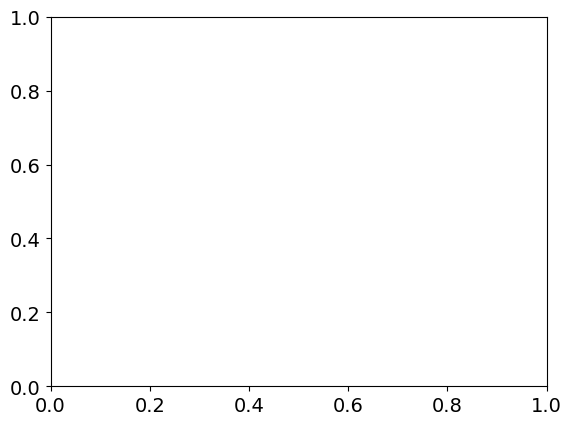

In [179]:
lp_branches = [branch.get_edge_length() for branch in lp_tree.traverse_postorder()]

plt.hist(lp_branches, bins=100, color='blue', alpha=0.3)
plt.title("LAML-Pro branch lengths")

In [ ]:

pet_branches = [branch.get_edge_length() for branch in pet_tree.traverse_postorder() if branch.get_edge_length() is not None]
plt.hist(pet_branches, bins=100, color='green', alpha=0.3)
plt.title("PETracer branch lengths")

456


Text(0.5, 1.0, 'PETracer polytomy depth')

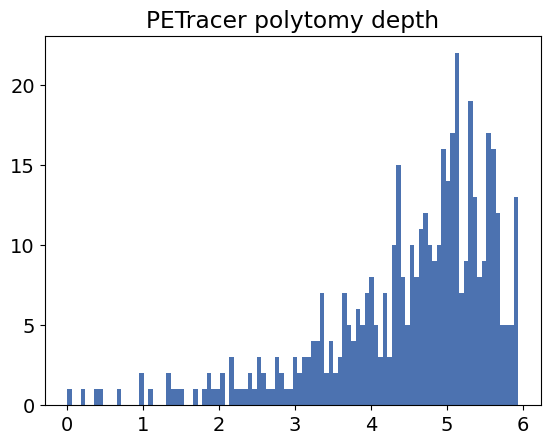

In [180]:
polytomies = 0
polytomy_depth = []
for node in pet_tree.traverse_postorder():
    if node.is_leaf():
        continue
    else:
        if len(node.children) >= 2:
            polytomies += 1
            polytomy_depth.append(pet_tree.distance_between(node, pet_tree.root))
            # print([child.get_edge_length() for child in node.children])
pet_polytomies = polytomies
print(pet_polytomies)
plt.hist(polytomy_depth, bins=100)
plt.title("PETracer polytomy depth")

694


Text(0.5, 1.0, 'LAML-Pro polytomy depth')

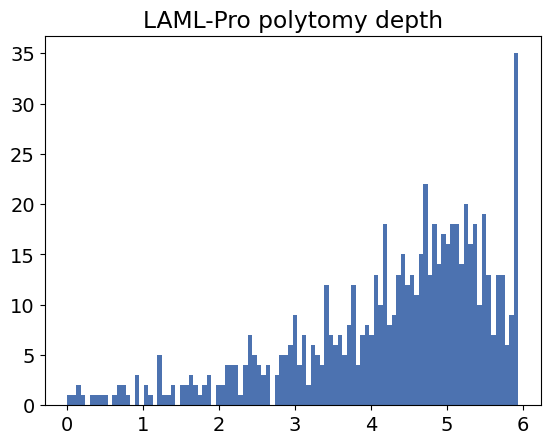

In [137]:
polytomies = 0
polytomy_depth = []

for node in lp_tree.traverse_postorder():
    if node.is_leaf():
        continue
    else:
        if len(node.children) >= 2:
            polytomies += 1
            polytomy_depth.append(pet_tree.distance_between(node, lp_tree.root))
            # print([child.get_edge_length() for child in node.children])

lp_polytomies = polytomies
print(lp_polytomies)
plt.hist(polytomy_depth, bins=100)
plt.title("LAML-Pro polytomy depth")

In [312]:
min(pet_branches), min(lp_branches)

(0.060000001333455726, 0.05999815514464819)

In [313]:
1e-6 * 22426.560424245945

0.022426560424245946

In [314]:
0.06 * 22426.560424245945

1345.5936254547566

In [181]:
diffusion_scale = (var_x + var_y)/(2*tau)
print("diffusion_scale", diffusion_scale)

diffusion_scale 3737.7600707076576


In [182]:
lp_tree.scale_edges(tau/lp_tree.height())
lp_tree.scale_edges(diffusion_scale)
print("Tree heights", lp_tree.height())

Tree heights 6.0 22426.56042424595


In [183]:
add_internal_labels(lp_tree)
pet_tree.is_rooted = False

In [184]:
lp_tree.write_tree_newick(lp_tree_fname[:-7] + ".scaled.newick")

In [185]:
lp_tree_fname[:-7] + ".scaled.newick"

'/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1_cmat/fastlaml_colonies_cmat_fastlaml_colonies_clone3.petracer.neighbor_joining_tree.round2_tree.scaled.newick'

In [1858]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# ---------- helpers unchanged except for concise bin labels ----------
def _upper_tri_pairs(index):
    n = len(index)
    iu = np.triu_indices(n, k=1)
    return pd.DataFrame({"obs1": index.values[iu[0]],
                         "obs2": index.values[iu[1]],
                         "i": iu[0], "j": iu[1]})

def _short_binlabel(cat):
    if pd.isna(cat):
        return "All"
    # cat is a pandas Interval
    a = f"{cat.left:.3f}".rstrip("0").rstrip(".")
    b = f"{cat.right:.1f}".rstrip("0").rstrip(".")
    return f"[{a}–{b})"

def _prep_long_df(centroids_df, distmat, dist_scale=0.5, detection_rate=None,
                  detection_bin_edges=None, tree_bin_edges=None):
    ids = centroids_df.index.intersection(distmat.index).intersection(distmat.columns)
    if len(ids) < 3:
        raise ValueError("Need ≥3 overlapping cells across centroids and dist matrix.")
    C = centroids_df.loc[ids, ["centroid_x", "centroid_y"]].astype(float)
    D_tree = distmat.loc[ids, ids].astype(float).values * float(dist_scale)

    XY = C.values
    D_spatial = squareform(pdist(XY, metric="euclidean"))

    pairs = _upper_tri_pairs(C.index)
    pairs["spatial_distances"] = D_spatial[pairs["i"], pairs["j"]]
    pairs["tree_distances"]    = D_tree[pairs["i"], pairs["j"]]

    if detection_rate is not None:
        if isinstance(detection_rate, pd.DataFrame):
            if detection_rate.shape[1] != 1:
                raise ValueError("detection_rate DataFrame must have exactly one column.")
            detection_rate = detection_rate.iloc[:, 0]
        det = detection_rate.reindex(ids).astype(float)
        pairs["detection_1"] = pairs["obs1"].map(det)
        pairs["detection_2"] = pairs["obs2"].map(det)

        if detection_bin_edges is None:
            detection_bin_edges = np.arange(0.6, 1.01, 0.1)
        pairs["detection_bin_1"] = pd.cut(pairs["detection_1"], bins=detection_bin_edges, include_lowest=True)
        pairs["detection_bin_2"] = pd.cut(pairs["detection_2"], bins=detection_bin_edges, include_lowest=True)
        pairs = pairs[pairs["detection_bin_1"].notna() & (pairs["detection_bin_1"] == pairs["detection_bin_2"])].copy()
        pairs["detection_bin"] = pairs["detection_bin_1"].map(_short_binlabel)
    else:
        pairs["detection_bin"] = "All"

    if tree_bin_edges is None:
        tree_bin_edges = np.arange(0, 6, 1)
    pairs["tree_bin"] = pd.cut(pairs["tree_distances"], bins=tree_bin_edges, include_lowest=True)
    pairs = pairs[pairs["tree_bin"].notna()].copy()

    grouped = (
        pairs.groupby(["tree_bin", "detection_bin"])["spatial_distances"]
             .agg(spatial_mean="mean", spatial_sd="std", n="count")
             .reset_index()
    )
    grouped["spatial_se"] = grouped["spatial_sd"] / np.sqrt(grouped["n"].clip(lower=1))
    grouped["tree_distance"] = grouped["tree_bin"].apply(lambda x: (x.left + x.right) / 2)

    perm_mean = pairs["spatial_distances"].mean()
    perm_se   = pairs["spatial_distances"].std(ddof=1) / np.sqrt(len(pairs))
    grouped["permuted_mean"] = perm_mean
    grouped["permuted_se"]   = perm_se

    return grouped.sort_values(["detection_bin", "tree_distance"]), pairs

def binwise_pearson(pairs_df):
    out = []
    for det_bin, g in pairs_df.groupby("detection_bin"):
        x = g["tree_distances"].values
        y = g["spatial_distances"].values
        if np.std(x) == 0 or np.std(y) == 0 or len(x) < 3:
            r, p = np.nan, np.nan
        else:
            r, p = pearsonr(x, y)
        out.append({"detection_bin": str(det_bin), "n_pairs": len(g), "pearson_r": r, "p_value": p})
    return pd.DataFrame(out).sort_values("detection_bin")

def _fmt_sig(x, sig=2):
    """Format number with `sig` significant digits (handles NaN/inf)."""
    if x is None or (isinstance(x, float) and (np.isnan(x) or not np.isfinite(x))):
        return "nan"
    return f"{x:.{sig}g}"

def plot_spatial_vs_tree_line(grouped_df, pairs_df, ax=None, ylimit=(0, 350),
                              title=None, legend_loc="below"):
    # (same header as before)
    ctx = {
        "font.size": 8,
        "axes.titlesize": 9,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,  # slightly bigger for readability
    }
    with mpl.rc_context(ctx):
        if ax is None:
            fig, ax = plt.subplots(figsize=(2.6, 2.8), dpi=300, layout="constrained")

        # --- baseline (unchanged except dashed) ---
        xvals = np.sort(grouped_df["tree_distance"].unique())
        perm = grouped_df.drop_duplicates(subset=["permuted_mean", "permuted_se"])[["permuted_mean", "permuted_se"]].iloc[0]
        ax.plot(xvals, np.full_like(xvals, perm["permuted_mean"]), color="black", linewidth=1, linestyle="--")
        ax.fill_between(xvals,
                        perm["permuted_mean"] - perm["permuted_se"],
                        perm["permuted_mean"] + perm["permuted_se"],
                        color="black", alpha=0.15, linewidth=0)

        # --- correlations per detection bin (unchanged logic) ---
        corr_df = binwise_pearson(pairs_df)
        corr_map = {row["detection_bin"]: row for _, row in corr_df.iterrows()}

        colors = ["#0072B2", "#E69F00", "#009E73", "#CC79A7", "#56B4E9", "#D55E00", "#F0E442"]
        hue_vals = sorted(grouped_df["detection_bin"].dropna().unique())

        handles, labels = [], []
        for i, h in enumerate(hue_vals):
            sub = grouped_df[grouped_df["detection_bin"] == h].sort_values("tree_distance")
            if sub.empty:
                continue
            col = colors[i % len(colors)]
            line, = ax.plot(sub["tree_distance"], sub["spatial_mean"], label=str(h), color=col, linewidth=1.8)
            ax.fill_between(sub["tree_distance"],
                            sub["spatial_mean"] - sub["spatial_se"],
                            sub["spatial_mean"] + sub["spatial_se"],
                            color=col, alpha=0.25, linewidth=0)

            r = corr_map[h]["pearson_r"] if h in corr_map else np.nan
            p = corr_map[h]["p_value"]   if h in corr_map else np.nan
            lab = f"{h} (r={_fmt_sig(r,2)}, p={_fmt_sig(p,2)})"
            handles.append(line); labels.append(lab)

        ax.set_ylim(*ylimit)
        ax.set_xlabel("Phylo. dist. (days)")
        ax.set_ylabel("Mean spatial dist. (μm)")
        ax.set_xticks(np.arange(np.floor(xvals.min()), np.ceil(xvals.max()) + 1, 2))
        if title:
            ax.set_title(title)

        # --- legend BELOW the axis ---
        if handles:
            ax.legend(handles, labels, title="Detection rate",
                      loc="upper center", bbox_to_anchor=(0.5, -0.18),
                      ncol=1, frameon=False)

        # add a bit more bottom room if needed
        try:
            plt.tight_layout()
        except Exception:
            pass

        return corr_df

def plot_correlation_linepanels(centroids_df, pet_distmat, lp_distmat=None, detection_rate=None,
                                pet_title="PETracer", lp_title="LAML-Pro",
                                dist_scale=0.5, detection_bin_edges=None, tree_bin_edges=None,
                                ylimit=(0, 350), figsize=(6.6, 2.8), outfile=None):
    pet_grouped, pet_pairs = _prep_long_df(
        centroids_df, pet_distmat, dist_scale=dist_scale,
        detection_rate=detection_rate,
        detection_bin_edges=detection_bin_edges,
        tree_bin_edges=tree_bin_edges
    )

    if lp_distmat is not None:
        lp_grouped, lp_pairs = _prep_long_df(
            centroids_df, lp_distmat, dist_scale=dist_scale,
            detection_rate=detection_rate,
            detection_bin_edges=detection_bin_edges,
            tree_bin_edges=tree_bin_edges
        )
        fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=300, sharey=True,
                                 gridspec_kw={"wspace": 0.6}, layout="constrained")
        pet_corr = plot_spatial_vs_tree_line(pet_grouped, pet_pairs, ax=axes[0], ylimit=ylimit, title=pet_title)
        lp_corr  = plot_spatial_vs_tree_line(lp_grouped,  lp_pairs,  ax=axes[1], ylimit=ylimit, title=lp_title)
        corr_tables = {"PET": pet_corr, "LP": lp_corr}
    else:
        fig, ax = plt.subplots(1, 1, figsize=(figsize[0]/2, figsize[1]), dpi=300, layout="constrained")
        pet_corr = plot_spatial_vs_tree_line(pet_grouped, pet_pairs, ax=ax, ylimit=ylimit, title=pet_title)
        corr_tables = {"PET": pet_corr}

    if outfile:
        fig.savefig(outfile, bbox_inches="tight")
    return fig, corr_tables


/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_52102/151249297.py:63: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_52102/151249297.py:63: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_52102/151249297.py:79: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc

  detection_bin  n_pairs  pearson_r        p_value
0   [0.599–0.7)    14358   0.156261   3.673043e-79
1     [0.7–0.8)     6613   0.158533   1.772859e-38
2     [0.8–0.9)    24095   0.139961  1.155382e-105
3       [0.9–1)     2242   0.116888   2.847124e-08


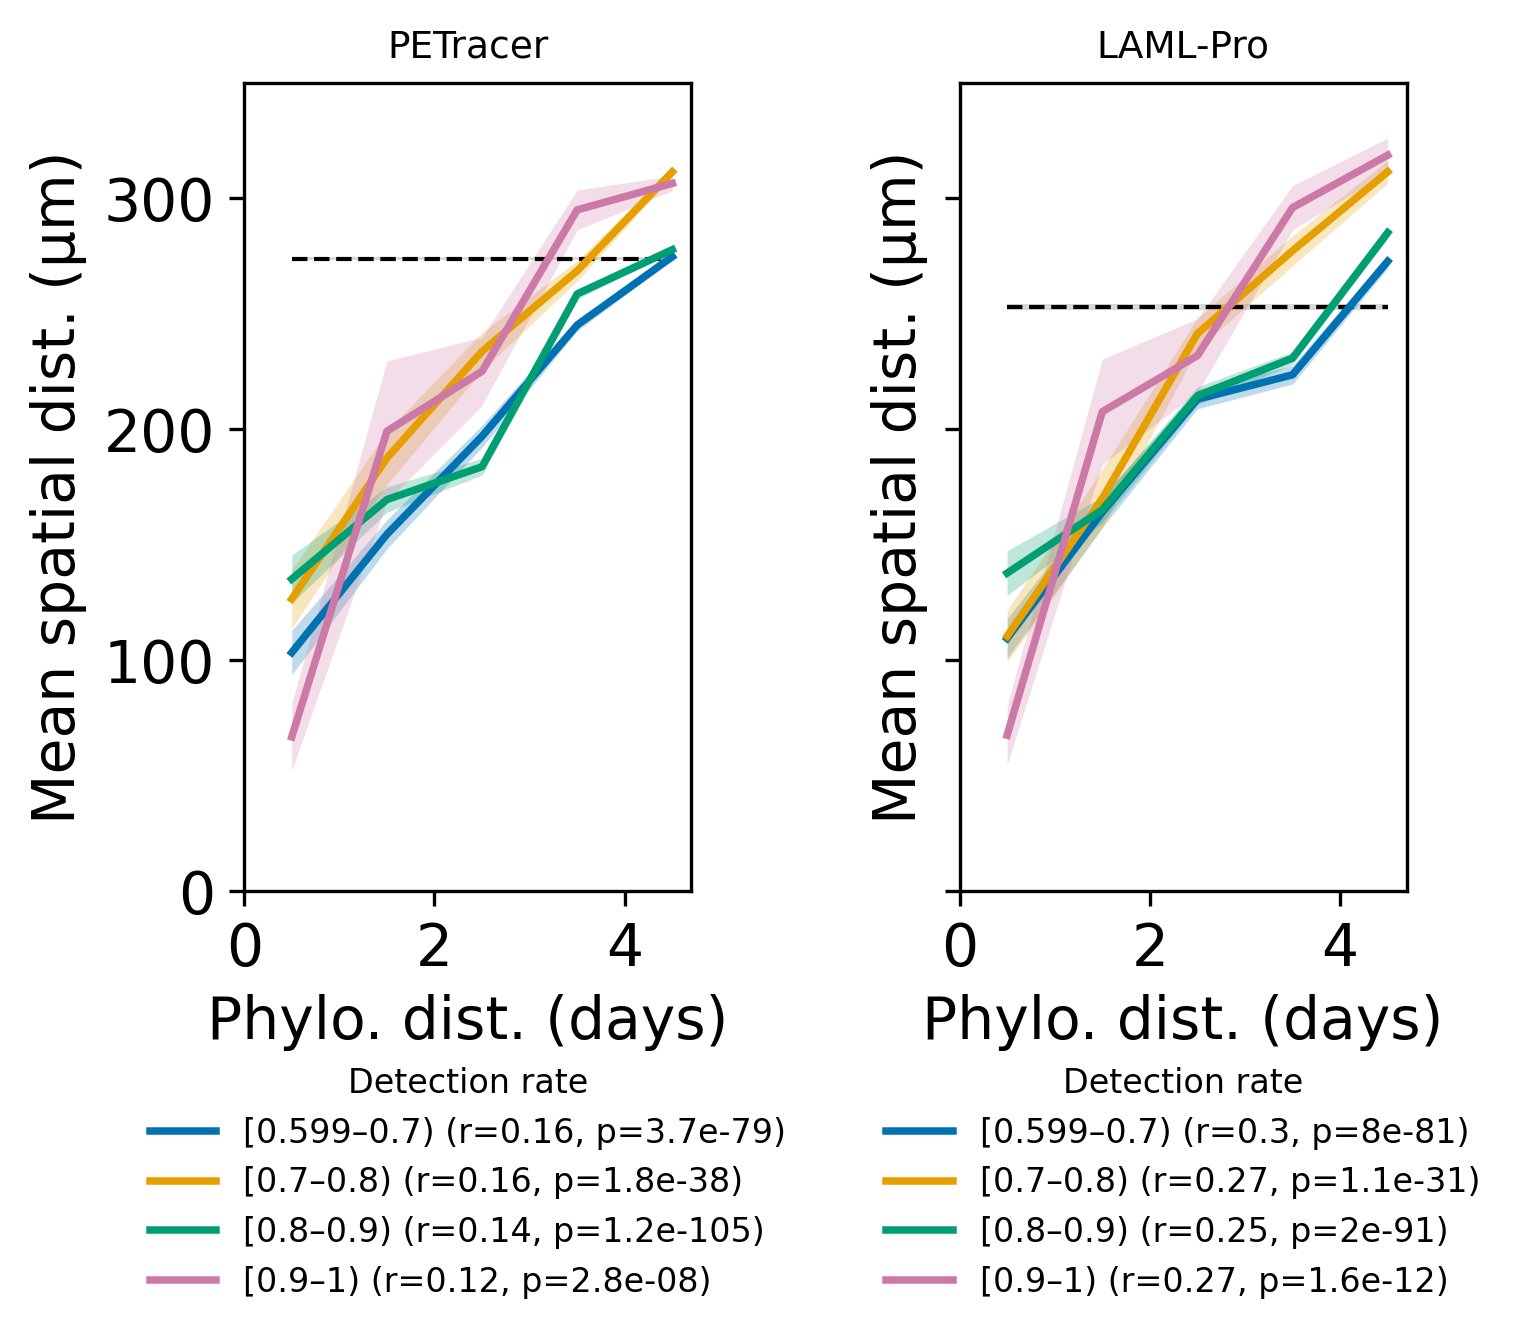

In [1859]:

fig, corr = plot_correlation_linepanels(
    centroids_df, pet_distmat, lp_distmat=lp_distmat,
    detection_rate=detection_rate,
    dist_scale=0.5,
    detection_bin_edges=np.arange(0.6, 1.01, 0.1),
    pet_title="PETracer",
    lp_title="LAML-Pro",
    tree_bin_edges=np.arange(0, 6, 1),
    ylimit=(0, 350),
    figsize=(5.0, 3.5),
    outfile=f"{plotdir}/colonies_colony{colony}_exp1_spatial_vs_tree_linepanels.pdf"
)
print(corr["PET"])  # per-bin Pearson stats

# detection_rate = meta_df["detection_rate"]  # optional; index must match centroids_df
# fig = plot_correlation_linepanels(
#     centroids_df,
#     pet_distmat,
#     lp_distmat=lp_distmat,
#     detection_rate=detection_rate,          # or None to lump everything into "All"
#     pet_title="PETracer",
#     lp_title="LAML-Pro",
#     dist_scale=0.5,
#     detection_bin_edges=np.arange(0.6, 1.01, 0.1),
#     tree_bin_edges=np.arange(0, 6, 1),
#     ylimit=(0, 350),
#     figsize=(5.0, 2.5),
#     outfile=f"{plotdir}/colonies_colony{colony}_spatial_vs_tree_linepanels.pdf"
# )


In `PEtracer2025/colony_tracing/plot.py`, the function `spatial_distance_lineplot` generates the relevant plot in the paper. They stratify by detection rate, and plots mean spatial distance vs. binned tree distance with a "null" band. They subsample down to 20,000 pairs.

In [1739]:
print(corr["PET"])

  detection_bin  n_pairs  pearson_r        p_value
0   [0.599–0.7)    14358   0.156261   3.673043e-79
1     [0.7–0.8)     6613   0.158533   1.772859e-38
2     [0.8–0.9)    24095   0.139961  1.155382e-105
3       [0.9–1)     2242   0.116888   2.847124e-08


### create a new colony_h5ad with the lamlpro tree / hack to run the spatial correlation plotting code

In [169]:
lp_tree_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1_cmat/fastlaml_colonies_cmat_fastlaml_colonies_clone3.petracer.neighbor_joining_tree.round2_tree.newick"
lp_tree = treeswift.read_tree_newick(lp_tree_fname)

branch_thresh = 0.06
lp_tree.collapse_short_branches(branch_thresh)
lp_tree.scale_edges(6/lp_tree.height())
lp_tree.write_tree_newick(lp_tree_fname[:-7] + ".scaled6days.newick")

In [170]:
lp_tree_fname[:-7] + ".scaled6days.newick"

'/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1_cmat/fastlaml_colonies_cmat_fastlaml_colonies_clone3.petracer.neighbor_joining_tree.round2_tree.scaled6days.newick'

In [171]:
output = subprocess.run(["python", "/Users/gc3045/git/laml2-experiments/real_data/analysis/helpers/newick_to_digraph_ete.py",
                         lp_tree_fname[:-7] + ".scaled6days.newick",
                         "-o", lp_tree_fname[:-7] + ".scaled6days.graphml"])

Root: internal_695
Nodes: 1197 | Edges: 1196
Leaves: 695 | Internal nodes: 502
Saved: /Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1_cmat/fastlaml_colonies_cmat_fastlaml_colonies_clone3.petracer.neighbor_joining_tree.round2_tree.scaled6days.graphml


In [172]:
lp_tree_digraph_fname = lp_tree_fname[:-7] + ".scaled6days.graphml"

In [173]:
lp_digraph = networkx.read_graphml(lp_tree_digraph_fname)

In [174]:
colony_pet_df.obst['3'] = lp_digraph

In [175]:
colony_pet_df.write_h5td("/Users/gc3045/git/laml2-experiments/real_data/analysis/colony_tracing_laml_exp1.h5td")

In [507]:
inputs_basename = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/"
lookup_codebook = pd.read_csv(inputs_basename + "/colonies_label_codebook.csv")
code_map = (lookup_codebook
            .copy())
code_map

,site,label,genotype
0,EMX1,unedited,0
1,EMX1,ACAAT,1
2,EMX1,AGTAC,2
3,EMX1,ATCAA,3
4,EMX1,ATTCG,4
5,EMX1,CCCTA,5
6,EMX1,CCGAT,6
7,EMX1,CCTTT,7
8,EMX1,GGACA,8
9,HEK3,unedited,0


In [508]:
lp_map_geno_df = pd.read_csv(lp_map_geno, skiprows=2, index_col=0)
lp_map_geno_df = lp_map_geno_df.loc[
    ~lp_map_geno_df.index.astype(str).str.startswith('internal_')
]

pet_input_geno_df = pd.read_csv(pet_input_geno)


In [509]:
np.mean(lp_map_geno_df.loc['colony-22252'] != lp_map_geno_df.loc['colony-22313'])

np.float64(0.0)

In [510]:
pet_geno_df = pet_input_geno_df[['cellBC', 'target_idx', 'pet_geno', 'pet_prob']].rename(columns={'cellBC': 'cell_name', 
                                                                                      'target_idx': 'target_site',
                                                                                      'pet_geno': 'pet_geno'})
pet_genocall_df = pet_geno_df.pivot(index='cell_name', columns='target_site', values='pet_geno').sort_index(axis=1).fillna(-1).astype(int)

In [511]:
np.mean((pet_genocall_df.loc['colony-22252'] != pet_genocall_df.loc['colony-22313']) & (pet_genocall_df.loc['colony-22252'] != -1) & ((pet_genocall_df.loc['colony-22313']) != -1) )

np.float64(0.020833333333333332)

In [512]:
(pet_genocall_df.loc['colony-22252'] != pet_genocall_df.loc['colony-22313']) & (pet_genocall_df.loc['colony-22252'] != -1) & ((pet_genocall_df.loc['colony-22313']) != -1)

target_site
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41     True
42    False
43    False
44    False
45    False
46    False
47    False
dtype: bool

In [513]:
pet_genocall_df.loc[['colony-22252', 'colony-22313']]

target_site,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
cell_name,,,,,,,,,,,,,,,,,,,,,
colony-22252,0,0,5,-1,-1,-1,0,1,0,0,...,-1,4,5,8,3,2,8,-1,-1,-1
colony-22313,0,0,5,5,5,5,0,1,0,0,...,0,4,5,2,-1,-1,-1,0,0,0


In [514]:
num_duplicates = (pet_genocall_df.duplicated(keep=False)).sum()
num_duplicates

np.int64(0)

In [515]:
pet_genocall_df.shape

(832, 48)

In [516]:
A = pet_genocall_df.to_numpy()
eq = (A[:, None, :] == A[None, :, :]) | (A[:, None, :] == -1) | (A[None, :, :] == -1)
adj = eq.all(axis=2)
n = adj.shape[0]
seen = np.zeros(n, bool)
labels = -np.ones(n, int)
cid = 0
for i in range(n):
    if not seen[i]:
        stack = [i]; seen[i] = True; labels[i] = cid
        while stack:
            v = stack.pop()
            nxt = np.where(adj[v] & ~seen)[0]
            if nxt.size:
                seen[nxt] = True
                labels[nxt] = cid
                stack.extend(nxt.tolist())
        cid += 1

# Counts per relaxed-duplicate group
unique_cids, sizes = np.unique(labels, return_counts=True)
print("Group sizes:", sizes)                            # size of each group
print("Num groups:", len(sizes))
print("Rows in duplicate groups:", sizes[sizes > 1].sum())
print("Num duplicate groups:", (sizes > 1).sum())


Group sizes: [  1   1   1   1   1   1   1   1   1   1   3   1 203   1   2   1   1   1
   2   2   1   1   1   1   1   1   1   1   1   1   1   2   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   7   1   1   1   2   1   1   1   1   1   1   1   1   1   1   2
   1   1   5   1   1   1   1   1   1   1   1   1   1   6   1   1   1   1
   2   1   1   1   1   1   1   1   1   1   1   1   1   1   2   1   1   1
   2   1   1   1   1   1   1   1   1   1   1   1   1   1   2   1   1   1
   1   1   2   1   2   1   1   1   1   1   4   3   1   1   1   1   1   1
   1   1   4   1   4   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   2   1   1   1   1   1   1   1   1   1   1   3   1   1   1   1   1
   1   1   3   5   3   1   1   1   1   1   1   1   1   1  10   1   1   1
   1   1   1   1   1   1   1   1   1   1   2   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   2   1   1   1   1   1   1   2   1   1   1
   1   1   1   2   1   1   1   1   1  

#### Explore allele conflicts defined by LAML-Pro

Ideally we would define allele conflicts with PETracer genotypes, but we don't have the discriminative probabilities for each state, just the max.

In [517]:
lp_map_probs = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1/fastlaml_colonies_clone3.petracer.neighbor_joining.binary_posterior_probs.csv"
lp_map_probs_df = pd.read_csv(lp_map_probs,index_col=0)
lp_map_probs_df = lp_map_probs_df.loc[[x for x in lp_map_probs_df.index if not x.startswith('internal_')]]

In [518]:
import re

def parse_prob_string(s, cast_key=int):
    if pd.isna(s) or s == "": 
        return {}
    out = {}
    for kv in str(s).split("/"):
        if not kv: 
            continue
        k, v = kv.split(":", 1)
        try:    k = cast_key(k.strip())
        except: k = k.strip()
        out[k] = float(v)
    return out

In [519]:
nested = (lp_map_probs_df
          .applymap(parse_prob_string)
          .to_dict(orient="index"))

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_29381/1996806988.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(parse_prob_string)


In [520]:
def top2(d):
    if not d or len(d) < 2:
        return False
    top2 = sorted(d.items(), key=lambda kv: kv[1], reverse=True)[:2]
    no_conflict = (top2[0][1] - top2[1][1]) <= 0.5
    is_silenced = (top2[0][0] == -1) | (top2[1][0] == -1)
    return top2, no_conflict & (not is_silenced) # {top2[0][0], top2[1][0]} == {0, 8}

Compute the allele conflict (argmax prob - secondargmax prob) and plot.

In [521]:
def _conflict_from_dict(d):
    if not d: 
        return np.nan
    vals = sorted(d.values())
    top = vals[-1]
    second = vals[-2] if len(vals) >= 2 else 0.0
    return top - second

# Build a wide DataFrame: rows = cells, cols = characters, values = conflict
conflict_df = pd.DataFrame({
    cell: {char: _conflict_from_dict(state_probs) for char, state_probs in chars.items()}
    for cell, chars in nested.items()
}).T

Text(0.5, 1.0, 'LP map: argmax - 2ndargmax')

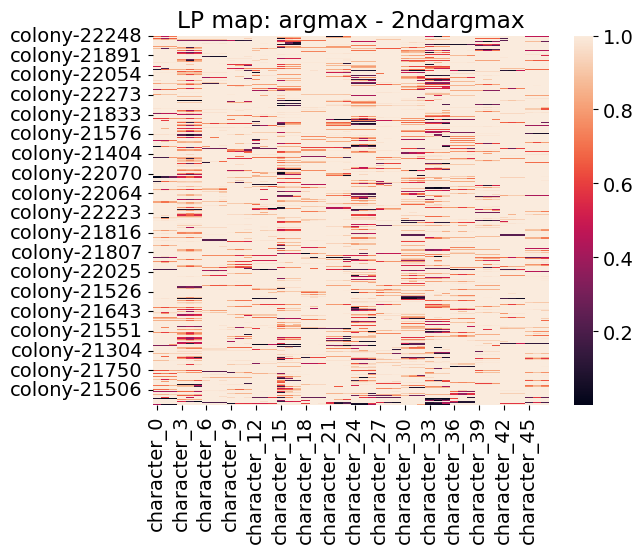

In [522]:
sns.heatmap(conflict_df)
plt.title("LP map: argmax - 2ndargmax")

Are cells with high allele conflict in the same way grouped together in the tree?

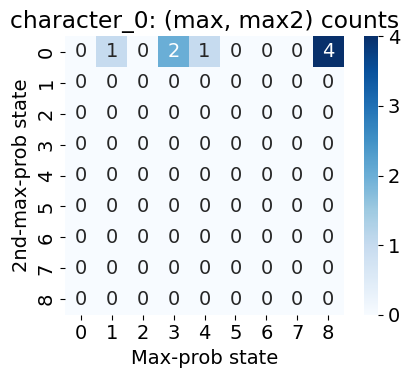

In [523]:
characters = lp_map_probs_df.columns.values

# gap between the two states must be >= 0.5
for character in characters:
    pairs = [top2(nested[x][character])[0] for x in nested if top2(nested[x][character])[1]]

    # 9x9 count matrix for states 0..8
    counts = pd.DataFrame(0, index=range(9), columns=range(9), dtype=int)
    for (top_tup, sectop_tup) in pairs:
        top_val = min(int(top_tup[0]), int(sectop_tup[0]))
        sectop_val = max(int(top_tup[0]), int(sectop_tup[0]))
        counts.iat[top_val, sectop_val] += 1

    # Heatmap (simple + readable)
    plt.figure(figsize=(5,4))
    ax = sns.heatmap(counts, annot=True, fmt='g', cmap="Blues", cbar=True, square=True)
    ax.set_xlabel("Max-prob state")
    ax.set_ylabel("2nd-max-prob state")
    ax.set_title(f"{character}: (max, max2) counts")
    plt.tight_layout()
    plt.show()

    break 

In [524]:
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize

save_dir = Path("/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/allele_conflicts")
save_dir.mkdir(parents=True, exist_ok=True)

characters = list(lp_map_probs_df.columns.values)

# --- compute counts for ALL characters, and global vmax ---
counts_list = []
vmax_global = 0

for character in characters:
    # Collect (top, second) tuples only when valid
    pairs = []
    for x in nested:
        res = top2(nested[x][character])
        if res[1]:  # validity flag
            pairs.append(res[0])  # ((top_state, top_prob), (sec_state, sec_prob))

    counts = pd.DataFrame(0, index=range(9), columns=range(9), dtype=int)
    for (top_tup, sectop_tup) in pairs:
        # order-insensitive: always put smaller state on y, larger on x
        a = min(int(top_tup[0]), int(sectop_tup[0]))
        b = max(int(top_tup[0]), int(sectop_tup[0]))
        counts.iat[a, b] += 1

    vmax_global = max(vmax_global, int(counts.to_numpy().max(initial=0)))
    counts_list.append((character, counts))

# --- layout: try 8 columns; rows computed to fit all ---
n = len(counts_list)
ncols = 8
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.6, nrows*2.6), constrained_layout=True)
axes = np.array(axes).ravel()

# shared normalization & existing cmap with 0 -> white
norm = Normalize(vmin=1e-9, vmax=max(1, vmax_global))  # tiny vmin so 0 uses "under"
cmap = plt.cm.get_cmap("Blues").copy()
cmap.set_under("white")

for i, (character, counts) in enumerate(counts_list):
    ax = axes[i]
    sns.heatmap(
        counts,
        ax=ax,
        cmap=cmap,
        norm=norm,
        vmin=norm.vmin,
        vmax=norm.vmax,
        cbar=False,
        square=True,
        annot=False,   # set True if you want numbers
        fmt='g',
        linewidths=0.3,
        linecolor='white',
    )
    ax.set_title(str(character), fontsize=9)
    ax.set_xlabel("Second-highest state", fontsize=8)
    ax.set_ylabel("Highest state", fontsize=8)
    ax.set_xticks(range(0, 9))
    ax.set_yticks(range(0, 9))
    ax.tick_params(axis='both', labelsize=7)
    ax.set_xticklabels(range(0, 9), fontsize=7)
    ax.set_yticklabels(range(0, 9), fontsize=7)

# turn off any unused axes (if n isn't multiple of ncols)
for j in range(n, len(axes)):
    axes[j].axis("off")

# single shared colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes[:n], fraction=0.02, pad=0.01)
cbar.set_label("Count")

fig.suptitle("Allele conflict counts (min(state), max(state)) across characters", fontsize=12)
outfile = save_dir / "allele_conflicts_all.png"
fig.savefig(outfile, dpi=300)
plt.close(fig)

print(f"Saved figure to: {outfile}")


/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_29381/1613834332.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Blues").copy()


Saved figure to: /Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/allele_conflicts/allele_conflicts_all.png


In [525]:
def expected_hamming_distance(p, q, normalize=True):
    """
    Expected Hamming distance between two probability vectors p, q.
    = 1 - sum_i p_i * q_i
    """
    p = np.asarray(p, float)
    q = np.asarray(q, float)
    if normalize:
        p = p / p.sum() if p.sum() > 0 else p
        q = q / q.sum() if q.sum() > 0 else q
    return float(1.0 - np.dot(p, q))

def expected_hamming_distance_nested(nested, cell_a, cell_b, character, states=range(9), normalize=True):
    """
    Expected Hamming distance between two cells' probability dicts at `character`.
    nested[cell][character] -> {state: prob}

    Returns: 1 - sum_i p_i q_i
    """
    if cell_a not in nested or cell_b not in nested:
        raise KeyError("cell_a or cell_b not in nested")
    if character not in nested[cell_a] or character not in nested[cell_b]:
        raise KeyError(f"{character} missing for one/both cells")

    da = nested[cell_a][character]
    db = nested[cell_b][character]

    p = np.array([float(da.get(s, 0.0)) for s in states], dtype=float)
    q = np.array([float(db.get(s, 0.0)) for s in states], dtype=float)

    if normalize:
        ps, qs = p.sum(), q.sum()
        if ps > 0: p = p / ps
        if qs > 0: q = q / qs

    return float(1.0 - np.dot(p, q))

##### Compute distance matrix from the trees

In [526]:
lp_distmat = distdict_to_df(lp_tree.distance_matrix(leaf_labels=True))
pet_distmat = distdict_to_df(pet_tree.distance_matrix(leaf_labels=True))

In [527]:
lp_distmat['colony-22252']['colony-22313']

np.float64(0.12008393901051947)

In [528]:
pet_distmat['colony-22252']['colony-22313']

np.float64(7938.595216215923)

##### Plot allele conflict strength with a fixed dendrogram of the cells on the left

Text(0.5, 1.0, 'LP map: argmax - 2ndargmax')

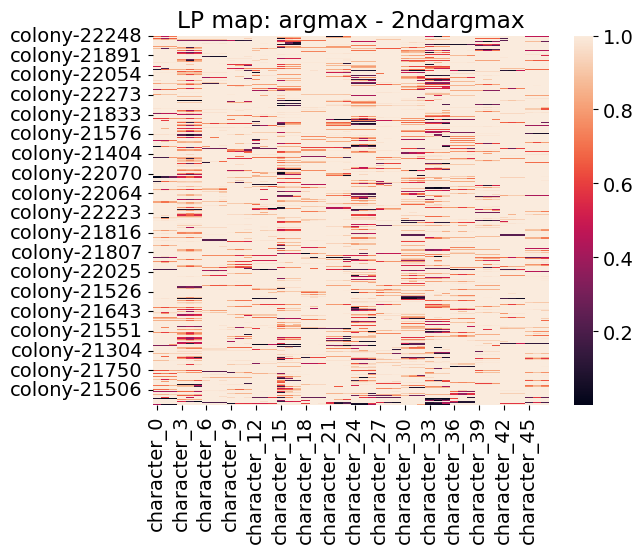

In [529]:
sns.heatmap(conflict_df)
plt.title("LP map: argmax - 2ndargmax")

<Axes: ylabel='node'>

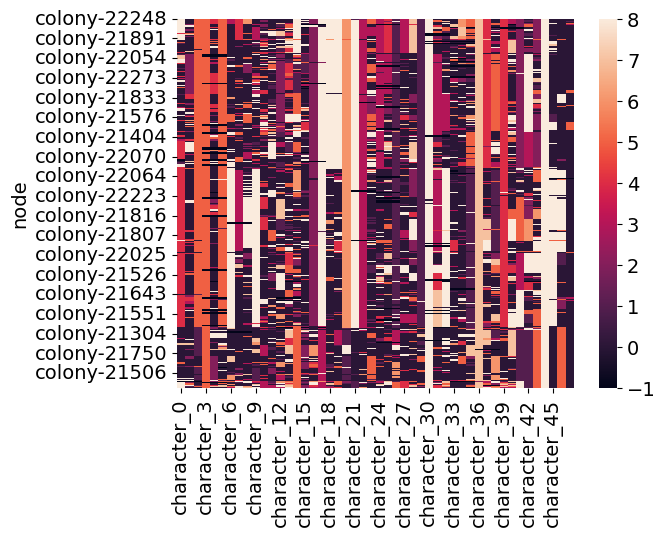

In [530]:
sns.heatmap(lp_map_geno_df)

In [531]:
from Bio import Phylo
from matplotlib.transforms import Bbox


In [532]:
newick_str = lp_tree.newick()

In [ ]:
# pip install biopython seaborn scipy matplotlib
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Phylo
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec


def tree_aligned_genos(
    lp_chars: pd.DataFrame,
    newick_str: str,
    metric: str = "hamming",
    method: str = "average",
    title: str = "Colony: LAML-Pro genotypes",
    vmin: int = -1, vmax: int = 8,
    outfile: str | None = None,
    show_cell_names: bool = True,
    tree_panel_ratio: float = 0.28,   # left panel width fraction for the tree
    dpi: int = 150,
):
    """
    Plot a genotype heatmap whose rows are ordered by a given Newick tree.
    Columns are clustered (and reordered) but no dendrogram is shown.
    The phylogenetic tree is drawn on the left without labels.

    Parameters
    ----------
    lp_chars : DataFrame
        Rows = nodes (must match some leaf names in Newick), cols = characters.
        Values are integer states; -1 is treated as a dedicated "missing" bin.
    newick_str : str
        Newick string describing the phylogenetic tree over (a superset of) the row labels.
    metric, method : str
        Distance metric and linkage for column clustering (e.g., hamming + average).
    title : str
        Title above the heatmap panel.
    vmin, vmax : int
        Discrete integer state range; include -1 if you want a bin for missing.
    outfile : str | None
        If provided, saves the figure to this path.
    show_cell_names : bool
        Whether to draw y-axis labels (cell/node names).
    tree_panel_ratio : float
        Fraction of figure width reserved for the tree (0–1).
    dpi : int
        Figure DPI.
    """

    # ---------- 1) Parse tree and determine row order ----------
    tree = Phylo.read(StringIO(newick_str), "newick")
    tree.ladderize(True)  # cosmetic
    leaves = [t.name for t in tree.get_terminals()]

    df = lp_chars.copy()
    df = df.apply(pd.to_numeric, errors="coerce").fillna(-1).astype(int)

    row_order = [x for x in leaves if x in df.index]
    if not row_order:
        raise ValueError("No overlapping leaf names between Newick and DataFrame index.")
    df = df.loc[row_order]

    # ---------- 2) Cluster columns (no dendrogram displayed) ----------
    dists = pdist(df.values.T, metric=metric)
    Zc = linkage(dists, method=method, metric=metric)
    col_order = leaves_list(Zc)
    df_ord = df.iloc[:, col_order]

    # ---------- 3) Discrete palette (Okabe–Ito style) ----------
    categories = np.arange(vmin, vmax + 1)
    # build a palette long enough; keep index 0 grey for -1 if present
    # We'll map bins with BoundaryNorm so -1 gets its own bin.
    n_needed = len(categories)
    if n_needed > len(OKABE):
        # extend with repeated cycle if needed (rare)
        mult = int(np.ceil(n_needed / len(OKABE)))
        pal = (OKABE * mult)[:n_needed]
    else:
        pal = OKABE[:n_needed]
    cmap = ListedColormap(pal)
    bounds = np.arange(vmin - 0.5, vmax + 1.5, 1.0)
    norm = BoundaryNorm(bounds, cmap.N)

    # ---------- 4) Layout: left tree, right heatmap ----------
    fig = plt.figure(figsize=(8, 4.5), dpi=dpi) #, constrained_layout=True)
    gs = GridSpec(nrows=1, ncols=2, width_ratios=[tree_panel_ratio, 1 - tree_panel_ratio], wspace=0.0)
    ax_tree = fig.add_subplot(gs[0, 0])
    ax_heat = fig.add_subplot(gs[0, 1])
    plt.subplots_adjust(wspace=0.0)
    ax_tree.margins(x=0.0, y=0.0)

    # ----- Heatmap (no dendrogram) -----
    sns.heatmap(
        df_ord,
        ax=ax_heat,
        cmap=cmap, norm=norm, vmin=vmin, vmax=vmax,
        xticklabels=False,
        yticklabels=show_cell_names,
        cbar=False,
        rasterized=False,
    )
    ax_heat.set_title(title, fontsize=16)
    ax_heat.set_aspect('auto')

    ax_heat.set_xlabel("Target sites", fontsize=13)
    ax_heat.set_ylabel("Cell names" if show_cell_names else "", fontsize=13)
    ax_heat.tick_params(axis="both", labelsize=11)
    if show_cell_names:
        # ensure one label per row at centered positions
        n_rows = df_ord.shape[0]
        ax_heat.set_yticks(np.arange(n_rows) + 0.5)
        ax_heat.set_yticklabels(df_ord.index.tolist(), rotation=0, fontsize=11)
        ax_heat.yaxis.set_ticks_position('left')

    # Black border around heatmap to match your style
    for side in ("left", "right", "top", "bottom"):
        ax_heat.spines[side].set_visible(True)
        ax_heat.spines[side].set_linewidth(1.5)
        ax_heat.spines[side].set_edgecolor("black")

    # Shared horizontal colorbar (like your function)
    box_h = ax_heat.get_position()
    cax   = fig.add_axes([box_h.x1 + 0.004, box_h.y0, 0.018, box_h.height])  # tweak 0.004/0.018 if needed
    cbar  = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    # cbar = fig.colorbar(
    #     plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    #     ax=[ax_heat], orientation="vertical", fraction=0.08 #, pad=0.08
    # )
    cbar.set_ticks(categories)
    ticklabels = ["?/-1" if x == -1 else str(x) for x in categories]
    cbar.set_ticklabels(ticklabels)

    # ----- Tree (no labels) -----
    Phylo.draw(tree, axes=ax_tree, do_show=False, show_confidence=False, label_func=lambda _: None)
    for coll in ax_tree.collections:   # LineCollection used by Bio.Phylo
        coll.set_linewidth(0.4)        # e.g., 0.3–0.6 works well
    for ln in ax_tree.lines:           # just in case any Line2D were drawn
        ln.set_linewidth(0.4)
        
    ax_tree.invert_yaxis()          # top row = first leaf
    ax_tree.set_xmargin(0)
    x0, x1 = ax_tree.dataLim.x0, ax_tree.dataLim.x1
    ax_tree.set_xlim(x0 +0.01, x1 + 0.01)

    ax_tree.set_xticks([]); ax_tree.set_yticks([])
    ax_tree.set_xlabel(""); ax_tree.set_ylabel(""); ax_tree.set_title("")
    ax_tree.margins(x=0.0)
    # ax_tree.set_ylim(ax_heat.get_ylim()[0]-0.1, ax_heat.get_ylim()[1]-0.1)
    box_t = ax_tree.get_position(); box_h = ax_heat.get_position()
    ax_heat.set_position([box_t.x1, box_h.y0, box_h.width + (box_h.x0 - box_t.x1), box_h.height])
    ax_heat.set_position([box_t.x1 - 0.001, box_h.y0, (box_h.x1 - box_t.x1) + 0.001, box_h.height])

    for sp in ax_tree.spines.values():
        sp.set_visible(False)
        
    if outfile:
        fig.savefig(outfile, bbox_inches="tight", dpi=dpi)

    return fig, row_order, col_order


In [596]:
plotdir

'/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots'

In [612]:
lp_tree_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1/fastlaml_colonies_clone3.petracer.neighbor_joining.binary_tree.newick"
lp_tree = treeswift.read_tree_newick(lp_tree_fname)
newick_str = lp_tree.newick()

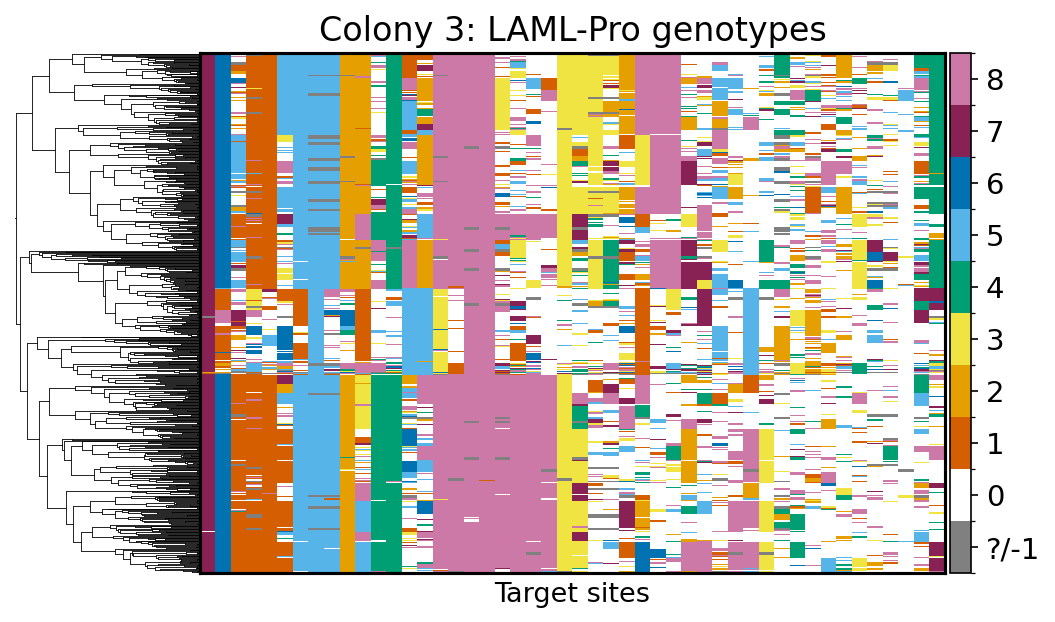

In [613]:
tmp_geno = lp_map_geno_df.copy()
#tmp_geno.columns = [x.split('_')[1] for x in lp_map_geno_df.columns]
fig, row_order, col_order = tree_aligned_genos(tmp_geno, newick_str,
                         metric="hamming", method="average",
                         title="Colony 3: LAML-Pro genotypes",
                         vmin=-1, vmax=8,
                         outfile=f"{plotdir}/colonies_colony3_lamlpro_tree_genotypes.pdf",
                         show_cell_names=False, tree_panel_ratio=0.2)

##### Add the heatmap showing the allele conflicts

In [536]:
def _conflict_from_dict(d):
    if not d: 
        return np.nan
    vals = sorted(d.values())
    top = vals[-1]
    second = vals[-2] if len(vals) >= 2 else 0.0
    return top - second

# Build a wide DataFrame: rows = cells, cols = characters, values = conflict
conflict_df = pd.DataFrame({
    cell: {char: _conflict_from_dict(state_probs) for char, state_probs in chars.items()}
    for cell, chars in nested.items()
}).T

In [537]:
def top2(d, conflict_thresh=0.3):
    if not d or len(d) < 2:
        return False
    top2 = sorted(d.items(), key=lambda kv: kv[1], reverse=True)[:2]
    no_conflict = ((top2[0][1] - top2[1][1]) <= conflict_thresh) & ((top2[0][1] + top2[1][1]) >= 0.6)
    is_silenced = (top2[0][0] == -1) | (top2[1][0] == -1)
    return top2, no_conflict & (not is_silenced) # {top2[0][0], top2[1][0]} == {0, 8}

In [538]:
cells  = list(nested.keys())
sites  = sorted({site for d in nested.values() for site in d.keys()})

# matrix with nullable integers so we can keep NAs
mat = pd.DataFrame(index=cells, columns=sites, dtype="Int64")

for cell, ts_dict in nested.items():
    for site, state_probs in ts_dict.items():
        res = top2(state_probs)          # ([(g1,p1),(g2,p2)], keep_flag) or False
        if not res: 
            continue
        (pairs, keep) = res
        if not keep:
            continue
        g1, g2 = pairs[0][0], pairs[1][0]
        if g1 == 0 or g2 == 0:
            other = g2 if g1 == 0 else g1
            if other != 0:
                mat.at[cell, site] = other

# mat now has the nonzero genotype for qualifying (cell, site) pairs; others are <NA>


In [539]:
mat = mat.astype(float)

In [540]:
tree = Phylo.read(StringIO(newick_str), "newick")
tree.ladderize(True)  # cosmetic
leaves = [t.name for t in tree.get_terminals()]

df = mat.copy()
df = df.apply(pd.to_numeric, errors="coerce").fillna(-1).astype(int)

row_order = [x for x in leaves if x in df.index]
if not row_order:
    raise ValueError("No overlapping leaf names between Newick and DataFrame index.")
df = df.loc[row_order]

df

,character_0,character_1,character_10,character_11,character_12,character_13,character_14,character_15,character_16,character_17,...,character_43,character_44,character_45,character_46,character_47,character_5,character_6,character_7,character_8,character_9
colony-22287,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
colony-22296,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
colony-22327,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
colony-22461,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
colony-22316,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
colony-21257,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
colony-21790,-1,-1,-1,-1,-1,-1,-1,2,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
colony-21917,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
colony-21358,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [541]:
print(df['character_32'].values)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8
 -1 -1  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [542]:
print(df['character_15'].values)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  8 -1  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8  8 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8 -1 -1
 -1 -1  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2

In [543]:
print(df['character_11'].values)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  6 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  8 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  6
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

We observe a lot of sisters in the tree with allele conflict. 
1. Let's quantify that.
2. Can we quantify where in the tree the MRCA pairs of cells sit? Was it some number of cell divisions ago?

In [544]:
for col in df.columns:
    print(df[col])
    break

colony-22287   -1
colony-22296   -1
colony-22327   -1
colony-22461   -1
colony-22316   -1
               ..
colony-21257   -1
colony-21790   -1
colony-21917   -1
colony-21358   -1
colony-21452    8
Name: character_0, Length: 695, dtype: int64


In [545]:
def mrca_height_from_root(tree, leaf_a: str, leaf_b: str):
    mrca = tree.mrca({leaf_a, leaf_b})
    
    return tree.distance_between(tree.root, mrca)

In [546]:
pairs = [] 
rows = df.index.to_list()
for col in df.columns:
    vals = df[col].to_numpy()
    # scan for *adjacent* equal, non -1 values
    for i in range(1, len(vals)):
        v, v_prev = vals[i], vals[i-1]
        if (v is not None) and (v_prev is not None) \
           and not (pd.isna(v) or pd.isna(v_prev)) \
           and v != -1 and v_prev != -1 and v == v_prev:
            pairs.append((rows[i-1], rows[i], col, int(v)))


In [547]:
pairs

[('colony-22228', 'colony-22151', 'character_0', 3),
 ('colony-22228', 'colony-22151', 'character_1', 4),
 ('colony-21653', 'colony-21574', 'character_12', 2),
 ('colony-22163', 'colony-22036', 'character_12', 2),
 ('colony-21653', 'colony-21574', 'character_14', 1),
 ('colony-22219', 'colony-22070', 'character_15', 8),
 ('colony-21332', 'colony-21545', 'character_15', 8),
 ('colony-21998', 'colony-21827', 'character_15', 2),
 ('colony-22020', 'colony-22005', 'character_15', 8),
 ('colony-21280', 'colony-22109', 'character_15', 2),
 ('colony-21851', 'colony-21838', 'character_16', 8),
 ('colony-21851', 'colony-21838', 'character_17', 8),
 ('colony-21774', 'colony-21359', 'character_18', 3),
 ('colony-22228', 'colony-22151', 'character_23', 3),
 ('colony-22339', 'colony-21836', 'character_23', 1),
 ('colony-22338', 'colony-22352', 'character_23', 8),
 ('colony-21256', 'colony-21461', 'character_23', 8),
 ('colony-21461', 'colony-22061', 'character_23', 8),
 ('colony-22199', 'colony-2223

In [548]:
heights = []
pairs_with_heights = []
for a, b, col, state in pairs:
    try:
        h = mrca_height_from_root(lp_tree, a, b)
        heights.append(h)
        pairs_with_heights.append((a, b, col, state, h))
    except StopIteration:
        # leaf not found in tree; skip gracefully
        continue

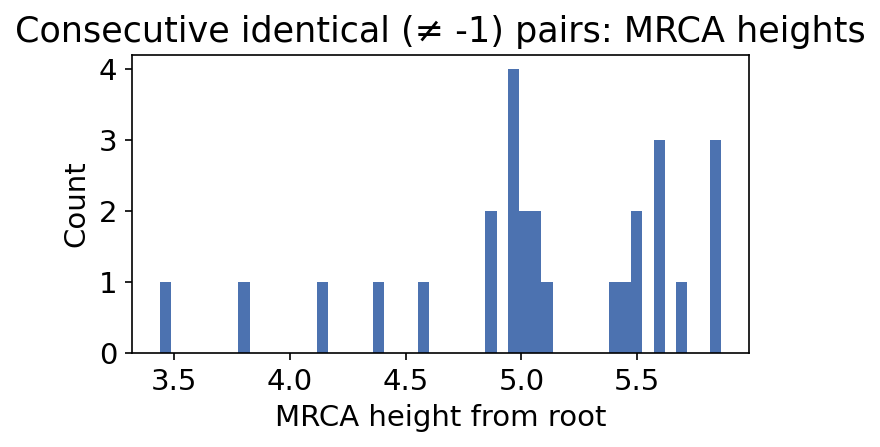

count    27.000000
mean      5.077198
std       0.615497
min       3.438663
25%       4.912005
50%       5.053012
75%       5.555513
max       5.861425
Name: height_from_root, dtype: float64


In [549]:
pair_df = pd.DataFrame(pairs_with_heights, columns=["cell_a","cell_b","character","state","height_from_root"])

# Plot the distribution
plt.figure(figsize=(5,3.2), dpi=150)
plt.hist(heights, bins=50)
plt.xlabel("MRCA height from root")
plt.ylabel("Count")
plt.title("Consecutive identical (≠ -1) pairs: MRCA heights")
plt.tight_layout()
plt.show()

# If you also want a quick numeric summary:
summary = pair_df["height_from_root"].describe()
print(summary)

So most of the allele conflicts group together in the tree, and they have MRCA which are low in the tree, as expected. 

In [550]:
0.7 * 6

4.199999999999999

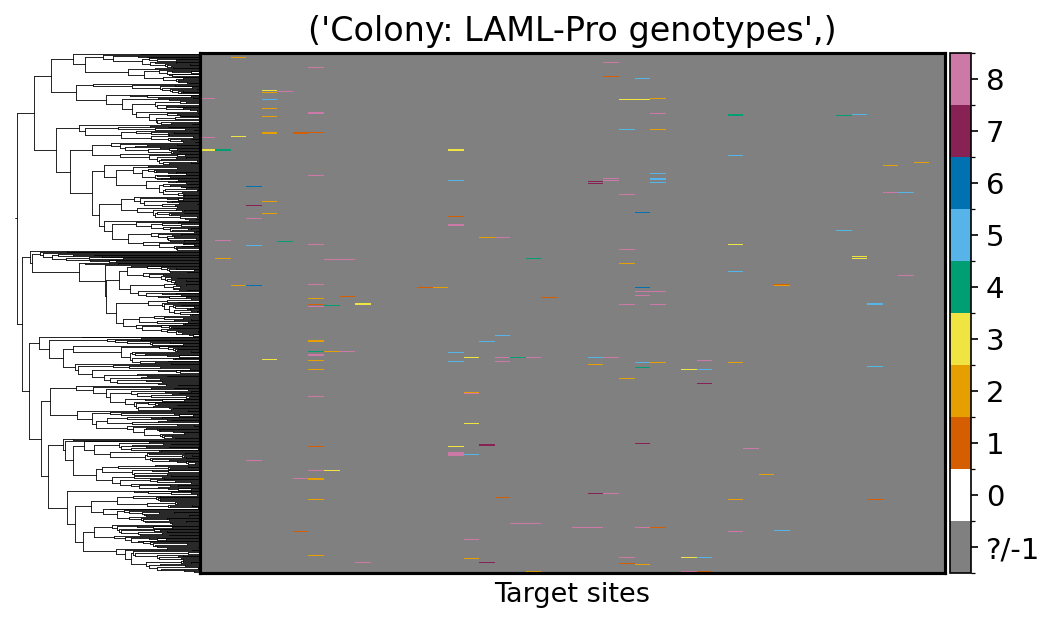

In [551]:
lp_chars = mat
metric = "hamming",
method = "average",
title  = "Colony: LAML-Pro genotypes",
vmin = -1
vmax = 8
dpi = 150
tree_panel_ratio = 0.2
show_cell_names = False

tree = Phylo.read(StringIO(newick_str), "newick")
tree.ladderize(True)  # cosmetic
leaves = [t.name for t in tree.get_terminals()]

df = lp_chars.copy()
df = df.apply(pd.to_numeric, errors="coerce").fillna(-1).astype(int)

row_order = [x for x in leaves if x in df.index]
if not row_order:
    raise ValueError("No overlapping leaf names between Newick and DataFrame index.")
df = df.loc[row_order]

# ---------- 2) Cluster columns (no dendrogram displayed) ----------
# dists = pdist(df.values.T, metric=metric)
# Zc = linkage(dists, method=method, metric=metric)
# col_order = leaves_list(Zc)
# df_ord = df.iloc[:, col_order]
df_ord = df

# ---------- 3) Discrete palette (Okabe–Ito style) ----------
categories = np.arange(vmin, vmax + 1)
# build a palette long enough; keep index 0 grey for -1 if present
# We'll map bins with BoundaryNorm so -1 gets its own bin.
n_needed = len(categories)
if n_needed > len(OKABE):
    # extend with repeated cycle if needed (rare)
    mult = int(np.ceil(n_needed / len(OKABE)))
    pal = (OKABE * mult)[:n_needed]
else:
    pal = OKABE[:n_needed]
cmap = ListedColormap(pal)
bounds = np.arange(vmin - 0.5, vmax + 1.5, 1.0)
norm = BoundaryNorm(bounds, cmap.N)

# ---------- 4) Layout: left tree, right heatmap ----------
fig = plt.figure(figsize=(8, 4.5), dpi=dpi) #, constrained_layout=True)
gs = GridSpec(nrows=1, ncols=2, width_ratios=[tree_panel_ratio, 1 - tree_panel_ratio], wspace=0.0)
ax_tree = fig.add_subplot(gs[0, 0])
ax_heat = fig.add_subplot(gs[0, 1])
plt.subplots_adjust(wspace=0.0)
ax_tree.margins(x=0.0, y=0.0)

# ----- Heatmap (no dendrogram) -----
sns.heatmap(
    df_ord,
    ax=ax_heat,
    cmap=cmap, norm=norm, vmin=vmin, vmax=vmax,
    xticklabels=False,
    yticklabels=show_cell_names,
    cbar=False,
    rasterized=False,
)
ax_heat.set_title(title, fontsize=16)
ax_heat.set_aspect('auto')

ax_heat.set_xlabel("Target sites", fontsize=13)
ax_heat.set_ylabel("Cell names" if show_cell_names else "", fontsize=13)
ax_heat.tick_params(axis="both", labelsize=11)
if show_cell_names:
    # ensure one label per row at centered positions
    n_rows = df_ord.shape[0]
    ax_heat.set_yticks(np.arange(n_rows) + 0.5)
    ax_heat.set_yticklabels(df_ord.index.tolist(), rotation=0, fontsize=11)
    ax_heat.yaxis.set_ticks_position('left')

# Black border around heatmap to match your style
for side in ("left", "right", "top", "bottom"):
    ax_heat.spines[side].set_visible(True)
    ax_heat.spines[side].set_linewidth(1.5)
    ax_heat.spines[side].set_edgecolor("black")

# Shared horizontal colorbar (like your function)
box_h = ax_heat.get_position()
cax   = fig.add_axes([box_h.x1 + 0.004, box_h.y0, 0.018, box_h.height])  # tweak 0.004/0.018 if needed
cbar  = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
# cbar = fig.colorbar(
#     plt.cm.ScalarMappable(norm=norm, cmap=cmap),
#     ax=[ax_heat], orientation="vertical", fraction=0.08 #, pad=0.08
# )
cbar.set_ticks(categories)
ticklabels = ["?/-1" if x == -1 else str(x) for x in categories]
cbar.set_ticklabels(ticklabels)

# ----- Tree (no labels) -----
Phylo.draw(tree, axes=ax_tree, do_show=False, show_confidence=False, label_func=lambda _: None)
for coll in ax_tree.collections:   # LineCollection used by Bio.Phylo
    coll.set_linewidth(0.4)        # e.g., 0.3–0.6 works well
for ln in ax_tree.lines:           # just in case any Line2D were drawn
    ln.set_linewidth(0.4)
    
ax_tree.invert_yaxis()          # top row = first leaf
ax_tree.set_xmargin(0)
x0, x1 = ax_tree.dataLim.x0, ax_tree.dataLim.x1
ax_tree.set_xlim(x0 +0.01, x1 + 0.01)

ax_tree.set_xticks([]); ax_tree.set_yticks([])
ax_tree.set_xlabel(""); ax_tree.set_ylabel(""); ax_tree.set_title("")
ax_tree.margins(x=0.0)
# ax_tree.set_ylim(ax_heat.get_ylim()[0]-0.1, ax_heat.get_ylim()[1]-0.1)
box_t = ax_tree.get_position(); box_h = ax_heat.get_position()
ax_heat.set_position([box_t.x1, box_h.y0, box_h.width + (box_h.x0 - box_t.x1), box_h.height])
ax_heat.set_position([box_t.x1 - 0.001, box_h.y0, (box_h.x1 - box_t.x1) + 0.001, box_h.height])

for sp in ax_tree.spines.values():
    sp.set_visible(False)
    
if outfile:
    fig.savefig(outfile, bbox_inches="tight", dpi=dpi)


##### Compare phylogenetic distance against expected hamming distance

In [552]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- helpers ---
def _vec_from_prob_dict_excluding(d, *, include_states, exclude_states=(-1,), normalize=True):
    r"""
    Build a probability vector over (include_states \ exclude_states).
    If normalize=True, renormalizes mass away from excluded states.
    Returns (vec, total_mass_kept).
    """
    S = [s for s in include_states if s not in exclude_states]
    v = np.array([float(d.get(s, 0.0)) for s in S], dtype=float)
    mass = v.sum()
    if normalize and mass > 0:
        v = v / mass
    return v, mass

def expected_hamming_between_cells_allchars_weighted(
    nested, cell_a, cell_b, *,
    characters=None,
    include_states=(-1,0,1,2,3,4,5,6,7,8),
    exclude_states=(-1,),
    normalize=True,
    reduction="mean",   # "mean" or "sum"
    weighted=True       # if True and reduction="mean", weight by prob both non-missing
):
    r"""
    Weighted expected Hamming across characters, ignoring missing states (e.g., -1).

    Per character:
      - Drop excluded states
      - Renormalize remaining mass (if normalize=True)
      - Distance = 1 - dot(p, q)
      - Weight w = (mass_p_kept * mass_q_kept)  (probability both are non-missing)

    If weighted=True and reduction="mean": return sum(w*d)/sum(w) (NaN if sum(w)==0).
    If weighted=False and reduction="mean": simple mean of d over characters with w>0.
    """
    if (cell_a not in nested) or (cell_b not in nested):
        return np.nan

    chars = set(nested[cell_a].keys()).intersection(nested[cell_b].keys())
    if characters is not None:
        chars = chars.intersection(characters)
    if not chars:
        return np.nan

    vals, weights = [], []
    for ch in chars:
        da = nested[cell_a][ch]
        db = nested[cell_b][ch]

        p, mass_p = _vec_from_prob_dict_excluding(da, include_states=include_states,
                                                  exclude_states=exclude_states, normalize=normalize)
        q, mass_q = _vec_from_prob_dict_excluding(db, include_states=include_states,
                                                  exclude_states=exclude_states, normalize=normalize)

        if mass_p <= 0 or mass_q <= 0 or len(p) == 0:
            continue

        d = 1.0 - float(np.dot(p, q))
        w = float(mass_p * mass_q)
        vals.append(d)
        weights.append(w)

    if not vals:
        return np.nan

    if reduction == "sum":
        return float(np.sum(np.array(vals) * np.array(weights)))

    # mean
    vals = np.asarray(vals, float)
    weights = np.asarray(weights, float)
    if weighted:
        wsum = weights.sum()
        return float(np.sum(vals * weights) / wsum) if wsum > 0 else np.nan
    else:
        return float(vals.mean())


In [553]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- compute mean expected Hamming (weighted, ignoring -1) for all pairs ---
cells = [c for c in lp_distmat.index if c in nested]  # align with nested
exp_ham = pd.DataFrame(np.nan, index=cells, columns=cells, dtype=float)

for i, a in enumerate(cells):
    exp_ham.iat[i, i] = 0.0
    for j in range(i+1, len(cells)):
        b = cells[j]
        d = expected_hamming_between_cells_allchars_weighted(
            nested, a, b,
            include_states=(-1,0,1,2,3,4,5,6,7,8),
            exclude_states=(-1,),   # don't penalize -1; it's ignored
            normalize=True,
            reduction="mean",       # <- mean expected Hamming per character
            weighted=True           # weight by prob both are non-missing
        )
        exp_ham.iat[i, j] = d
        exp_ham.iat[j, i] = d

# --- assemble pair table (upper triangle, finite only) ---
pairs = []
for i, a in enumerate(cells):
    for j in range(i+1, len(cells)):
        b = cells[j]
        phy = lp_distmat.loc[a, b]
        eh  = exp_ham.loc[a, b]
        if np.isfinite(phy) and np.isfinite(eh):
            pairs.append((a, b, phy, eh))

pairs_df = pd.DataFrame(pairs, columns=["cell_a", "cell_b", "phylo", "exp_hamming_mean"])

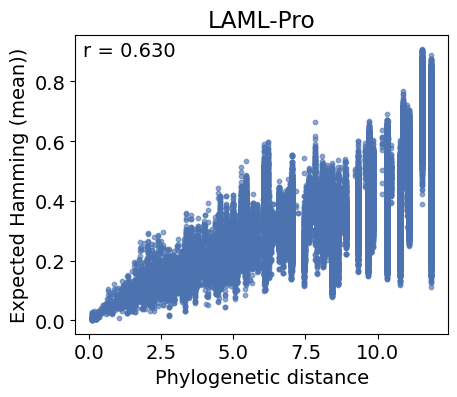

In [554]:

# --- scatter plot ---
plt.figure(figsize=(4.8, 4.2))
plt.scatter(pairs_df["phylo"], pairs_df["exp_hamming_mean"], s=10, alpha=0.6)
plt.xlabel("Phylogenetic distance")
plt.ylabel("Expected Hamming (mean))")
plt.title("LAML-Pro")

# optional: annotate Pearson r
if len(pairs_df) > 1:
    r = np.corrcoef(pairs_df["phylo"], pairs_df["exp_hamming_mean"])[0, 1]
    plt.text(0.02, 0.98, f"r = {r:.3f}", transform=plt.gca().transAxes, va="top")

plt.tight_layout()
plt.show()


In [555]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _argmax_state(prob_dict, states):
    """Argmax over a provided ordered list of states (can include -1)."""
    vals = [(s, float(prob_dict.get(s, 0.0))) for s in states]
    # If dict empty, return None (will be treated as missing/skip)
    if not vals:
        return None
    return max(vals, key=lambda kv: kv[1])[0]

def hamming_argmax_weighted_between_cells_allchars(
    nested, cell_a, cell_b, *,
    characters=None,
    states=(-1, 0, 1, 2, 3, 4, 5, 6, 7, 8),   # include -1 explicitly
    missing_codes=(-1,),                       # any of these => zero weight
    return_fraction=True
):
    """
    Weighted Hamming between argmax state vectors across characters.
    Weight = 0 if either argmax is in `missing_codes`, else 1.
    If return_fraction, returns sum(weight * [a!=b]) / sum(weight).

    Returns float in [0,1] or np.nan if no weighted comparisons.
    """
    if (cell_a not in nested) or (cell_b not in nested):
        return np.nan

    chars = set(nested[cell_a]).intersection(nested[cell_b])
    if characters is not None:
        chars = chars.intersection(characters)
    if not chars:
        return np.nan

    mism, wsum = 0.0, 0.0
    for ch in chars:
        da = nested[cell_a].get(ch, {})
        db = nested[cell_b].get(ch, {})
        if da is None or db is None:
            continue
        a = _argmax_state(da, states)
        b = _argmax_state(db, states)
        if a is None or b is None:
            continue

        w = 0.0 if (a in missing_codes or b in missing_codes) else 1.0
        if w > 0:
            mism += float(a != b)
            wsum += w

    if wsum == 0:
        return np.nan
    return (mism / wsum) if return_fraction else mism

# ---- Build weighted-argmax Hamming matrix aligned to lp_distmat ----
def build_weighted_argmax_hamming_matrix(nested, lp_distmat,
                                         states=(-1,0,1,2,3,4,5,6,7,8),
                                         missing_codes=(-1,),
                                         return_fraction=True):
    cells = [c for c in lp_distmat.index if c in nested]
    ham = pd.DataFrame(np.nan, index=cells, columns=cells, dtype=float)
    for i, a in enumerate(cells):
        ham.iat[i, i] = 0.0
        for j in range(i+1, len(cells)):
            b = cells[j]
            d = hamming_argmax_weighted_between_cells_allchars(
                nested, a, b, states=states, missing_codes=missing_codes,
                return_fraction=return_fraction
            )
            ham.iat[i, j] = d
            ham.iat[j, i] = d
    return ham

# ---- Scatter vs phylogenetic distance (like before) ----
def scatter_phylo_vs_weighted_hamming(lp_distmat, ham_mat, title="Phylo vs. weighted Hamming (argmax)"):
    cells = ham_mat.index.intersection(lp_distmat.index)
    pairs = []
    for i, a in enumerate(cells):
        for j in range(i+1, len(cells)):
            b = cells[j]
            phy = lp_distmat.loc[a, b]
            ham = ham_mat.loc[a, b]
            if np.isfinite(phy) and np.isfinite(ham):
                pairs.append((phy, ham))
    if not pairs:
        print("No comparable pairs found.")
        return
    x, y = np.array(pairs).T
    plt.figure(figsize=(4.6, 4.2))
    plt.scatter(x, y, s=9, alpha=0.6)
    plt.xlabel("Phylogenetic distance")
    ylabel = "Weighted Hamming (argmax)" if np.nanmax(y) <= 1.0 else "Weighted Hamming (argmax; count)"
    plt.ylabel(ylabel)
    plt.title(title)
    if len(x) > 1:
        r = np.corrcoef(x, y)[0, 1]
        plt.text(0.02, 0.98, f"r = {r:.3f}", transform=plt.gca().transAxes, va="top")
    plt.tight_layout()
    plt.show()

# ---- Example usage ----
# ham_mat = build_weighted_argmax_hamming_matrix(nested, lp_distmat)
# scatter_phylo_vs_weighted_hamming(lp_distmat, ham_mat)


In [556]:
ham_mat = build_weighted_argmax_hamming_matrix(nested, lp_distmat)

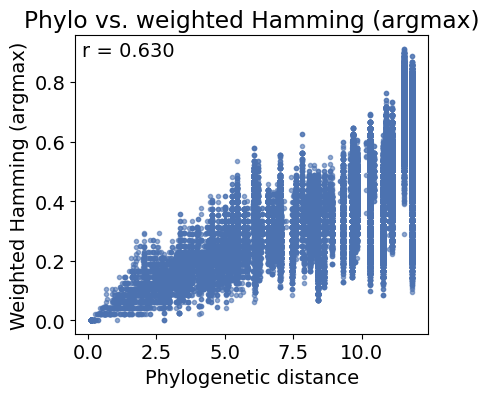

In [557]:
scatter_phylo_vs_weighted_hamming(lp_distmat, ham_mat)


In [558]:
lp_map_geno_df

,character_0,character_1,character_2,character_3,character_4,character_5,character_6,character_7,character_8,character_9,...,character_38,character_39,character_40,character_41,character_42,character_43,character_44,character_45,character_46,character_47
node,,,,,,,,,,,,,,,,,,,,,
colony-22248,8,0,5,5,4,5,3,4,6,0,...,0,4,3,2,0,2,8,0,0,0
colony-22093,8,0,5,5,4,5,3,4,6,0,...,0,4,3,2,0,2,8,0,0,0
colony-22259,8,0,5,5,4,5,3,4,6,0,...,0,4,3,2,5,2,8,0,0,0
colony-21312,8,0,5,5,4,5,3,4,6,0,...,0,4,3,2,1,2,8,0,0,0
colony-22096,8,0,5,5,4,5,3,4,6,0,...,0,4,3,2,0,2,8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
colony-21837,8,8,1,5,4,7,0,0,0,8,...,-1,4,7,8,1,5,8,0,5,0
colony-22034,8,1,5,5,7,7,5,8,6,0,...,5,7,5,8,1,5,8,0,5,0
colony-22131,8,0,0,5,0,7,8,8,6,4,...,5,0,5,8,1,5,8,0,5,0


In [559]:
# 0. subset down to the same cells
mask = pet_input_geno_df['cellBC'].astype(str).isin(
    lp_map_geno_df.index.astype(str)
)
pet_input_geno_df = pet_input_geno_df.loc[mask].copy()
pet_input_geno_df['cellBC'].nunique(), lp_map_geno_df.index.nunique()

(695, 695)

In [560]:
pet_input_geno_df['cellBC'].nunique()

695

In [561]:
pet_input_geno_df

,cellBC,intID,clone,target_site,pet_state,pet_prob,feature_0,feature_1,feature_2,feature_3,...,kde_geno,state0_prob,state1_prob,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob
0,colony-21229,intID1011,3,HEK3,CTTTG,1.000,151.968,382.201,93.477,108.180,...,5,-77.686381,-164.887733,-85.321183,-198.710112,-82.234303,-56.433557,-92.949801,-147.792755,-98.911797
1,colony-21230,intID1011,3,HEK3,unedited,0.993,158.407,176.455,146.892,136.513,...,0,-52.318358,-59.316048,-58.961131,-66.145116,-58.895207,-60.815081,-60.726905,-59.691610,-61.933258
2,colony-21240,intID1011,3,HEK3,unedited,0.950,132.650,127.877,152.962,191.891,...,0,-52.343101,-60.051285,-59.967729,-60.883260,-59.237272,-57.680469,-59.181425,-58.467382,-61.988406
3,colony-21241,intID1011,3,HEK3,unedited,1.000,615.597,1355.207,345.986,404.388,...,0,-67.966730,-742.139000,-742.812684,-743.046895,-740.652463,-302.932821,-742.493743,-714.983895,-742.775326
4,colony-21244,intID1011,3,HEK3,CTCTC,1.000,226.663,202.174,126.255,150.680,...,4,-67.088598,-153.104879,-231.964988,-393.707286,-53.772232,-90.444364,-79.078426,-109.032753,-78.389925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30085,colony-22490,intID911,3,RNF2,unedited,0.998,329.336,166.316,234.391,257.896,...,0,-53.591122,-223.470020,-738.116790,-744.391810,-549.394935,-86.006768,-68.724288,-63.426326,-62.340031
30086,colony-22494,intID911,3,RNF2,unedited,0.640,132.163,213.662,211.209,146.451,...,0,-54.519453,-59.181113,-63.428367,-64.154347,-61.389187,-58.586708,-57.351971,-59.310761,-58.256540
30087,colony-22501,intID911,3,RNF2,TTCCT,0.946,237.179,231.872,819.079,149.308,...,8,-66.832212,-61.880850,-60.919540,-62.804700,-77.334496,-66.221017,-72.624340,-65.925372,-54.665603
30088,colony-22504,intID911,3,RNF2,unedited,0.999,855.130,239.156,242.118,455.069,...,0,-59.495509,-79.401966,-738.116790,-744.391810,-743.083796,-86.231949,-72.551742,-78.251196,-76.588391


In [562]:
sum(pet_input_geno_df['pet_prob'] >= 0.7)

25929

In [563]:
1- (25929 / (695*48))

0.22275179856115113

In [564]:
1 - (26568 / (695 * 48))

0.20359712230215832

In [565]:
pet_cell_names = set(pet_input_geno_df['cellBC'])
lp_cell_names = set(lp_map_geno_df.index)

In [566]:
lp_map_geno_df.columns = [int(col.split('_')[1]) for col in lp_map_geno_df.columns]

In [567]:
lp_map_geno_df.shape, pet_genocall_df.shape

((695, 48), (832, 48))

In [568]:
lp_map_geno_df.eq(-1).sum().sum() / (695 * 48)

np.float64(0.018615107913669066)

In [569]:
pet_genocall_df.eq(-1).sum().sum() / (695 * 48)

np.float64(0.2951438848920863)

In [570]:
shared_sites = [c for c in pet_genocall_df.columns if c in lp_map_geno_df.columns]

In [571]:
lp_long = lp_map_geno_df[shared_sites].stack().reset_index()
lp_long.columns = ["cell_name", "target_site", "lp_state"]

In [572]:
# bm_long = pet_genocall_df[shared_sites].stack().reset_index()
# bm_long.columns = ["cell_name", "target_site", "pub_geno"]

In [573]:
# 1. merge pet_input_geno_df with lp_map_geno_df_filtered based on cell_name and target_idx
merged = pet_geno_df.merge(lp_long, on=['cell_name', 'target_site'])

In [574]:
merged = merged.rename(columns={'pet_geno': 'pub_geno',
                                'pet_prob': 'pub_pmax'})

In [575]:
summary_path = f"{plotdir}/colonies_colony{colony}_merged_summary.csv"
merged.to_csv(summary_path)

In [576]:
summary_path

'/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/colonies_colony3_merged_summary.csv'

In [610]:
output = subprocess.run(["Rscript", "/Users/gc3045/git/laml2-experiments/real_data/r_plotting/plot_genotypecall_summary.R",
                         "--path", summary_path,
                         "--othermethod", "PETracer",
                         "--outfile", f"{plotdir}/colonies_colony{colony}_genotypecall_summary.pdf"])
print("Genotype summary path printed to", f"{plotdir}/colonies_colony{colony}_genotypecall_summary.pdf")

New names:
• `` -> `...1`
Coordinate system already present.
ℹ Adding new coordinate system, which will replace the existing one.
Coordinate system already present.
ℹ Adding new coordinate system, which will replace the existing one.


Genotype summary path printed to /Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/colonies_colony3_genotypecall_summary.pdf


✅ Saved: /Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/colonies_colony3_genotypecall_summary.pdf


In [578]:
filt_pet_geno = pet_input_geno_df[['cellBC', 'pet_geno', 'pet_prob', 'target_idx','kde_geno']].rename(columns={'cellBC': 'cell_name',
                                                                                                               'target_idx': 'target_site',
                                                                                                               'pet_geno': 'bM_geno',
                                                                                                               'pet_prob': 'bM_pmax'})

In [579]:
summary_df = build_summary_df(filt_pet_geno, lp_map_geno_df)

[build_summary_df] merged rows: 26568 | LP matches: 26568 | both_present: 26568 | agree: 26010 (0.9789972899728997) | disagree_true: 558 (0.02100271002710027)


In [580]:
695 * 48, 26568/(695 * 48)

(33360, 0.7964028776978417)

In [581]:
# plot_genotype_confidence(summary_df, title=f"Colony {colony}: PETracer probabilities\nLAML-Pro vs baseMemoir genotypes",
#                          outfile=f"{plotdir}/colonies_clone{colony}_genotype_probabilities.pdf",bins=100)

Taking row and col order as input
Num categories: [-1  0  1  2  3  4  5  6  7  8]


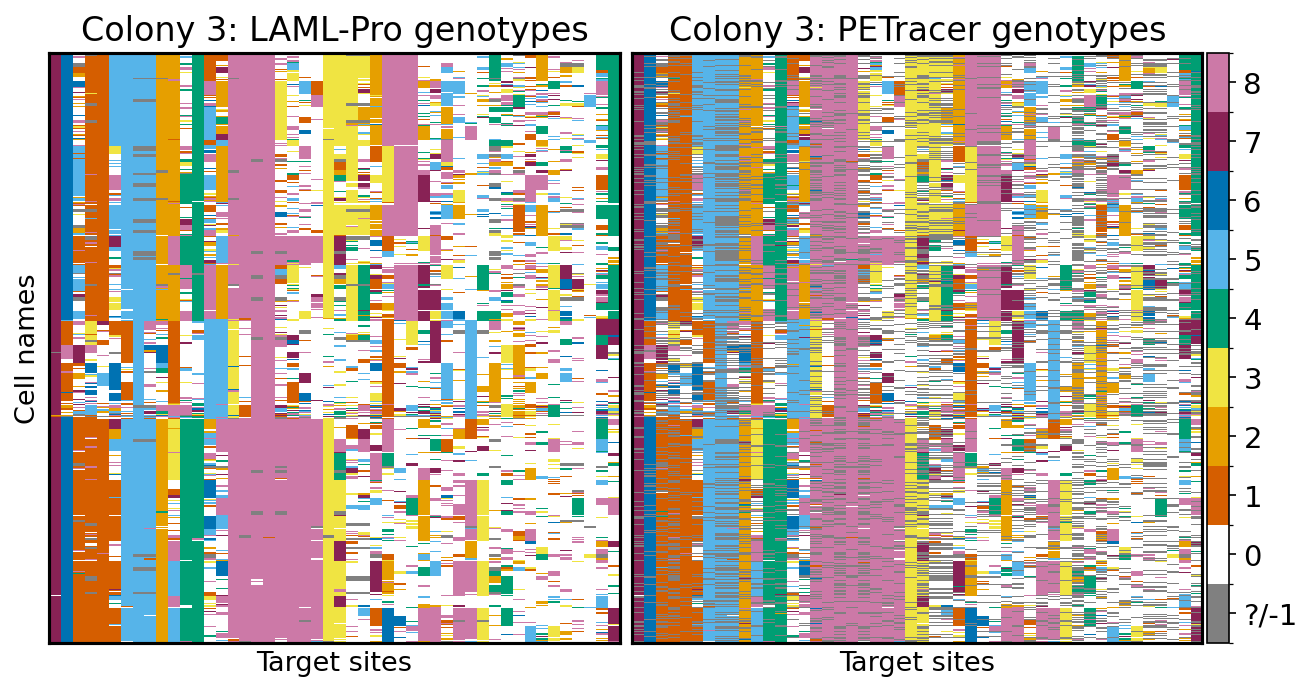

In [614]:
fig = clustermap_genos(pet_genocall_df, lp_map_geno_df, metric='hamming', method='single', title=f"Colony {colony}", other="PETracer", vmin=-1, vmax=8, show_cell_names=False,
                 outfile=f"{plotdir}/colonies_colony{colony}_genotype_comparison.pdf", row_order=row_order, col_order=col_order)

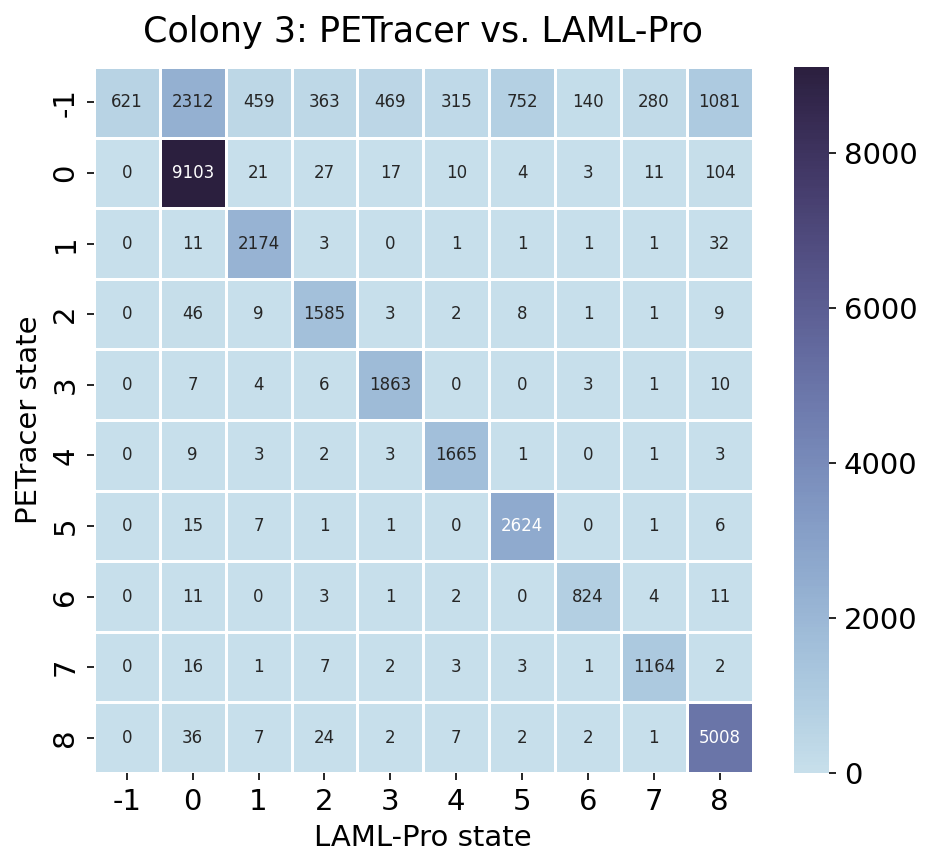

In [583]:
counts = plot_state_counts(pet_genocall_df, lp_map_geno_df, title=f"Colony {colony}: PETracer vs. LAML-Pro", ylabel="PETracer state", 
                           outfile=f"{plotdir}/colonies_colony{colony}_genotype_counts.pdf", use_state_labels=False)

In [584]:
states = ['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8']
# states=[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [585]:
counts.index = [str(x) for x in counts.index]
counts.columns = [str(x) for x in counts.columns]

In [586]:
stats_df = report_genotype_call_stats(counts, states=states, other_method="PETracer")
stats_df

,Missing/\nSilenced,0,1,2,3,4,5,6,7,8,Total
PETracer,0.2036,0.2788,0.0667,0.0499,0.0568,0.0506,0.0796,0.0257,0.0359,0.1525,1.0000
LAML-Pro (obs) prop. over all sites,0.0000,0.2774,0.0667,0.0497,0.0567,0.0507,0.0792,0.0250,0.0355,0.1554,0.7964
LAML-Pro (impute) prop. over all sites,0.0186,0.0693,0.0138,0.0109,0.0141,0.0094,0.0225,0.0042,0.0084,0.0324,0.2036
LAML-Pro (obs) prop. over observed sites,NaN,0.3483,0.0838,0.0624,0.0712,0.0636,0.0995,0.0314,0.0446,0.1952,1.0000
LAML-Pro (impute) prop. over missing sites,0.0914,0.3404,0.0676,0.0534,0.0691,0.0464,0.1107,0.0206,0.0412,0.1592,1.0000


In [587]:
t1 = stats_df.loc[['PETracer', 'LAML-Pro (obs) prop. over all sites']].rename(columns={"Missing/\nSilenced":"?/-1"})
t1

,?/-1,0,1,2,3,4,5,6,7,8,Total
PETracer,0.2036,0.2788,0.0667,0.0499,0.0568,0.0506,0.0796,0.0257,0.0359,0.1525,1.0000
LAML-Pro (obs) prop. over all sites,0.0000,0.2774,0.0667,0.0497,0.0567,0.0507,0.0792,0.0250,0.0355,0.1554,0.7964


In [588]:
t2= stats_df.loc[['LAML-Pro (obs) prop. over observed sites', 'LAML-Pro (impute) prop. over missing sites']].rename(columns={"Missing/\nSilenced":"?/-1"})
t2

,?/-1,0,1,2,3,4,5,6,7,8,Total
LAML-Pro (obs) prop. over observed sites,NaN,0.3483,0.0838,0.0624,0.0712,0.0636,0.0995,0.0314,0.0446,0.1952,1.0
LAML-Pro (impute) prop. over missing sites,0.0914,0.3404,0.0676,0.0534,0.0691,0.0464,0.1107,0.0206,0.0412,0.1592,1.0


In [589]:
save_df_to_pdf(t1, filename=f"{plotdir}/colonies_colony{colony}_genotype_call_stats_t1.pdf", title=None, floatfmt="{:.4f}",fontsize=16)
save_df_to_pdf(t2, filename=f"{plotdir}/colonies_colony{colony}_genotype_call_stats_t2.pdf", title=None, floatfmt="{:.4f}",fontsize=16)

/Users/gc3045/git/laml2-experiments/real_data/analysis/helpers/utils.py:697: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_disp = df_disp.applymap(lambda x: floatfmt.format(x) if isinstance(x, (int, float, np.floating)) else x)
/Users/gc3045/git/laml2-experiments/real_data/analysis/helpers/utils.py:697: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_disp = df_disp.applymap(lambda x: floatfmt.format(x) if isinstance(x, (int, float, np.floating)) else x)


'/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/colonies_colony3_genotype_call_stats_t2.pdf'